## Predicting uncertainty with (deep) neural networks

### Context

**NOTE**: This notebook has been adapted to ease its comprenhesion : https://github.com/sthorn/deep-learning-explorations/blob/master/predicting-uncertainty.ipynb*

### Imports 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import statistics as stat

%matplotlib inline

### Generate some random data

In [2]:
# Generate some linearly related data
np.random.seed(2019)

n_samples = 10000
x = np.random.random(n_samples)

sin_ = 0.4 * np.sin(x*4*np.pi)
eps = np.random.standard_exponential(size=n_samples) * sin_ # noise
y_1 = 2*x + 1 
y = y_1 + eps # linear data with noise

### Describe the generated data

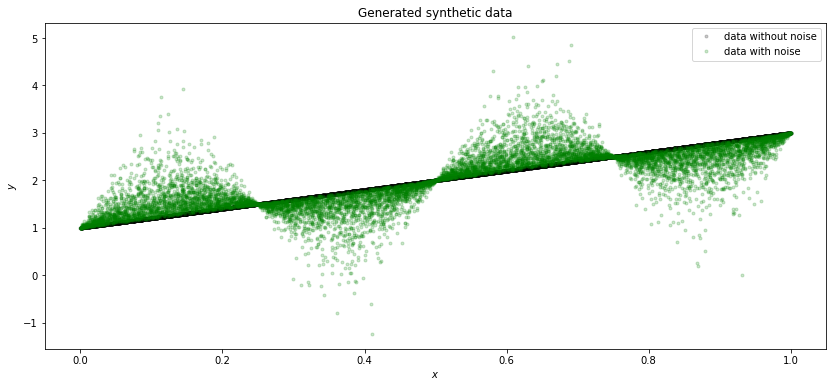

In [3]:
# Plot the data
plt.figure(figsize=(14,6))
plt.title('Generated synthetic data')

# plot data (with and without noise addition) 
plt.plot(x, y_1, '.', alpha=0.2, color='black' ) 
plt.plot(x, y, '.', alpha=0.2, color='green' ) 

plt.legend([r'data without noise',r'data with noise', r'$\mu$', r'$\pm\sigma$'])
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

### Prepare data for training

In [4]:
# Add in column of dummy zeros to represent sigma 
sigma = np.ones(y.size)
y = np.stack([y, sigma], axis=1)

In [5]:
# Reshape x for PyTorch
#x = x.reshape(10000, 1)
x = x.reshape(x.size, 1)

In [6]:
# Split into training and validation sets
n_validation = 500
x_val, x = x[:n_validation], x[n_validation:]
y_val, y = y[:n_validation], y[n_validation:]

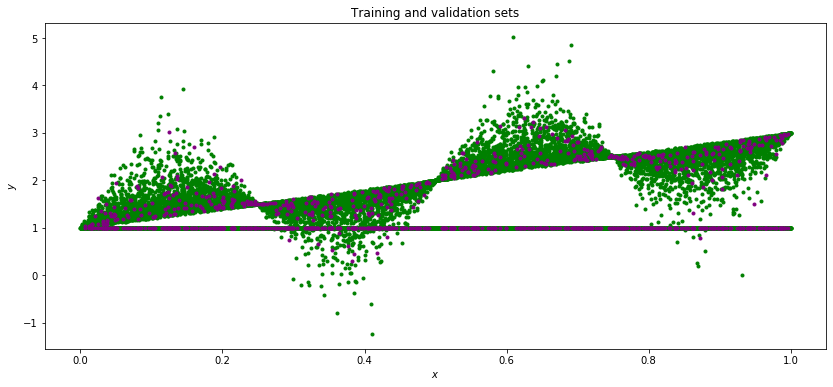

In [7]:
# Plot the data
plt.figure(figsize=(14,6))
plt.title('Training and validation sets')
plt.plot(x, y, '.', color= 'green')
plt.plot(x_val, y_val, '.', color='purple')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

In [8]:
# Convert x and y to PyTorch Variables on the GPU
dtype = torch.cuda.FloatTensor
x_t = Variable(torch.from_numpy(x).type(dtype))
y_t = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)

In [9]:
# Check shape ok for PyTorch - x should be (n x 1), y (n x 2)
x_t.shape, y_t.shape

(torch.Size([9500, 1]), torch.Size([9500, 2]))

## Experiment 

### Create a simple network 

In [10]:
# Create a simple two-layer network with one input (x) and two outputs (y, sigma)
n_inputs = 1
n_outputs = 2
n_hidden = 1000
model_1 = torch.nn.Sequential(torch.nn.Linear(n_inputs, n_hidden),
                            torch.nn.ReLU(),
                            torch.nn.Linear(n_hidden, n_outputs)
                           ).cuda()

In [11]:
# Adam optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)

### Custom loss function
This is where the magic happens.

In [13]:
def loss_variance_error(input, target):
    
    # Estimate target value for variance (sigma^2) with (y_pred - y)**2
    #
    #    actual y        is target[:,0]
    # predicted y        is input[:,0]
    #    actual variance is target[:,1] - estimated here
    # predicted variance is input[:,0]
    
    # Use 'requires_grad == False' to prevent PyTorch from trying to differentiate 'target'
    #target[:,1] = Variable((input[:,0].data - target[:,0].data)**2, 
    #                       requires_grad=False)  
    # Return MSE loss 
    return F.mse_loss(input, target)

### Training loop 
We train this simple model with batch size equal to the whole dataset.

In [14]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model_1(x_t)
    
    # Calculate loss
    loss = loss_variance_error(y_pred, y_t)
    if i%500 == 0: print(f'epoch: {i:4} loss: {loss.data.item():.3}',)

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

epoch:    0 loss: 2.3
epoch:  500 loss: 0.0725
epoch: 1000 loss: 0.0689
epoch: 1500 loss: 0.0641
epoch: 2000 loss: 0.0586
epoch: 2500 loss: 0.0533
epoch: 3000 loss: 0.0487
epoch: 3500 loss: 0.0452
epoch: 4000 loss: 0.0428
epoch: 4500 loss: 0.0414
epoch: 5000 loss: 0.0406
epoch: 5500 loss: 0.0402
epoch: 6000 loss: 0.04
epoch: 6500 loss: 0.0399
epoch: 7000 loss: 0.0399
epoch: 7500 loss: 0.0398
epoch: 8000 loss: 0.0398
epoch: 8500 loss: 0.0398
epoch: 9000 loss: 0.0398
epoch: 9500 loss: 0.0398


### Get predictions for validation set 

In [15]:
# Get predicted y and sigma for validation set
x_val_t = Variable(torch.from_numpy(x_val).type(dtype)) 
pred_1 = model_1(x_val_t)

# prediction of the response variables
y_pred_1 = pred_1[:,0].cpu().data
sigma_pred_1 = pred_1[:,1].cpu().data

### Plot results

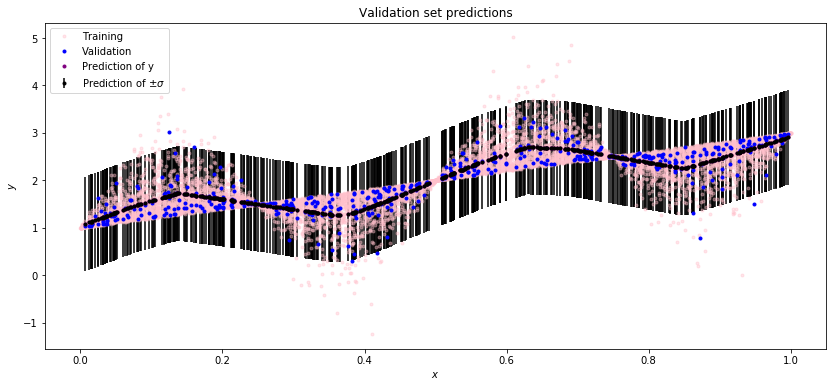

In [16]:
# Plot predictions and their errors
fig, ax1 = plt.subplots(figsize=(14,6))

ax1.plot(x, y[:,0], '.', alpha=0.4, color='pink')
ax1.plot(x_val, y_val[:,0], '.', color='blue')
ax1.plot(x_val, y_pred_1, '.', color='purple')
ax1.errorbar(x_val, y_pred_1, yerr=sigma_pred_1, fmt='.k');

ax1.set_xlabel(r'$x$');
ax1.set_ylabel(r'$y$');
ax1.set_title('Validation set predictions');
ax1.legend([r'Training', r'Validation', r'Prediction of y','Prediction of $\pm \sigma$'], loc='upper left', );

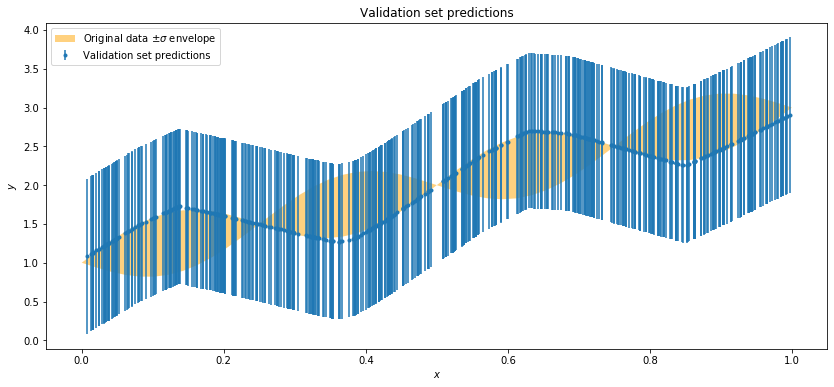

In [17]:
# Plot predictions and their errors
plt.figure(figsize=(14,6))
plt.errorbar(x_val, y_pred_1, yerr=np.sqrt(sigma_pred_1) , fmt='.'); 

# One standard-deviation envelope
xs = np.linspace(0.0, 1.0, 50)
err = 0.4*np.sin(xs*4*np.pi)
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.title('Validation set predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Validation set predictions'], loc='upper left', );

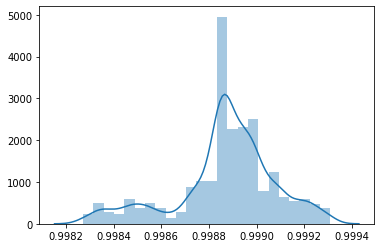

In [25]:
import seaborn as sns
sns.distplot(np.sqrt(sigma_pred_1))

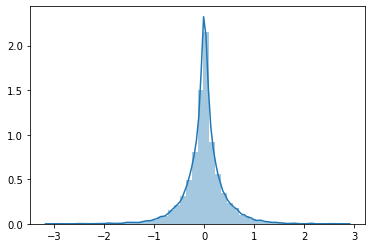

In [19]:
sns.distplot(eps)

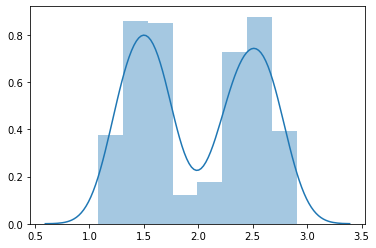

In [20]:
sns.distplot(y_pred_1)

In [21]:
x = np.random.random(n_samples)

sin_ = 0.4 * np.sin(x*4*np.pi)
eps = np.random.standard_exponential(size=n_samples) * sin_ # noise
y_1 = 2*x + 1 
y = y_1 + eps # linear data with noise

real_sigma = (y_1-y)**2

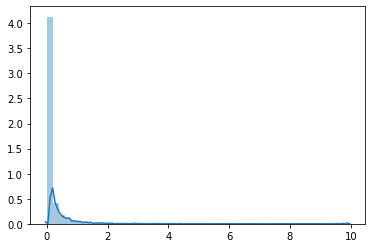

In [22]:
sns.distplot(real_sigma)

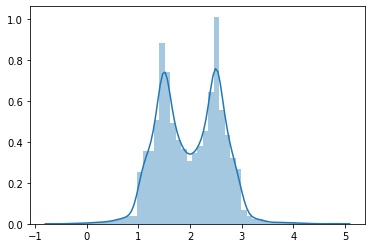

In [23]:
sns.distplot(y)

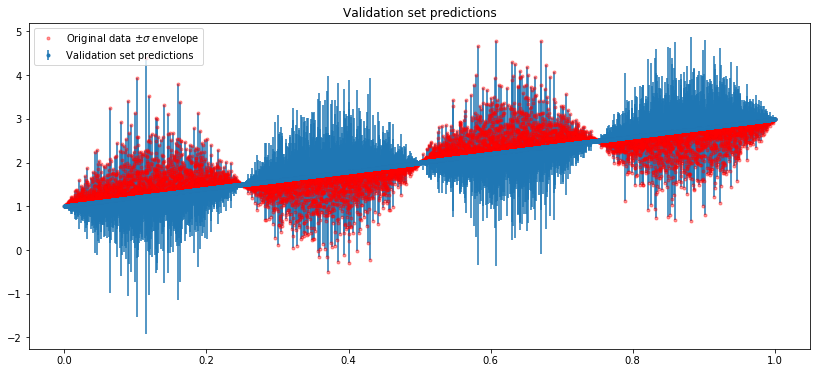

In [24]:
import math
# Plot predictions and their errors
fig, ax1 = plt.subplots(figsize=(14,6))

ax1.plot(x, y, '.', alpha=0.4, color='red')
plt.errorbar(x, y_1, yerr=np.sqrt(real_sigma) , fmt='.'); 

# One standard-deviation envelope

plt.title('Validation set predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Validation set predictions'], loc='upper left');